# 气候爬虫

1. `面`转`点`
2. 基于`点`经纬度爬取天气数据写入
3. 根据近邻关系将`点`天气信息赋给`线`小节


## 创建点数据

In [1]:
# 导入geopandas库
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

In [13]:
# 读取北京市矢量边界范围
beijing = gpd.read_file("../rawdata/北京市行政边界.shp")
# 以0.5度为距离创建区域内的空间点要素
x_coords = np.arange(115.3, 117.7, 0.1)
y_coords = np.arange(39.4, 41.5, 0.1)
points = [Point(x, y) for x in x_coords for y in y_coords]

In [14]:
# 缓冲区裁剪
buffer = beijing.buffer(0.1)
points = gpd.GeoDataFrame([[str(round(point.x,1)),str(round(point.y,1)),point] for point in points if buffer.contains(point)[0]], columns=['longitude','latitude','geometry'])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36008\2418094985.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = beijing.buffer(0.1)


In [15]:
points.to_file('../rawdata/北京市行政边界点.shp')

<Axes: >

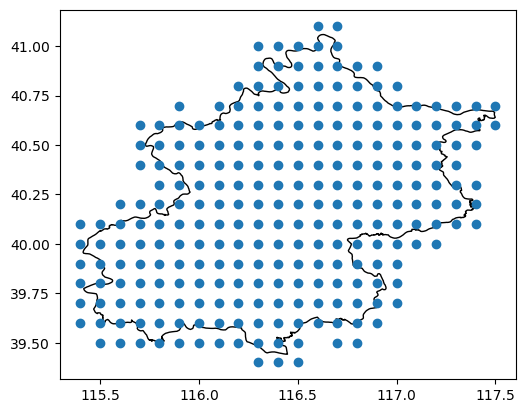

In [16]:
import matplotlib.pyplot as plt
ax = plt.subplot()
plt.plot()
beijing.plot(ax=ax,color="none")
points.plot(ax=ax)

## 基于点经纬度爬取天气数据

In [1]:
# 导入requests库和pandas库
import requests
import geopandas as gpd
import time

In [2]:
# 读取元数据
gdf = gpd.read_file("../rawdata/北京市行政边界点.shp")

In [3]:
# 定义气象信息储存表、提取要素表
weather_lst0, weather_lst1, weather_lst2 = [], [], []
from_idx = 0
name_lst = ["tempMax","tempMin","textDay","precip"]
n = len(name_lst)

提示
- daily.fxDate 预报日期
- daily.tempMax 预报当天最高温度
- daily.tempMin 预报当天最低温度
- daily.iconDay 预报白天天气状况的图标代码，图标可通过天气状况和图标下载
- daily.textDay 预报白天天气状况文字描述，包括阴晴雨雪等天气状态的描述
- daily.iconNight 预报夜间天气状况的图标代码，图标可通过天气状况和图标下载
- daily.textNight 预报晚间天气状况文字描述，包括阴晴雨雪等天气状态的描述
- daily.wind360Day 预报白天风向360角度
- daily.windDirDay 预报白天风向
- daily.windScaleDay 预报白天风力等级
- daily.windSpeedDay 预报白天风速，公里/小时
- daily.wind360Night 预报夜间风向360角度
- daily.windDirNight 预报夜间当天风向
- daily.windScaleNight 预报夜间风力等级
- daily.windSpeedNight 预报夜间风速，公里/小时
- daily.precip 预报当天总降水量，默认单位：毫米
- daily.humidity 相对湿度，百分比数值
- daily.pressure 大气压强，默认单位：百帕

In [8]:
# 遍历dataframe中的每一行
for index, row in gdf.loc[from_idx:,:].iterrows():
    # 设置请求的url和参数
    url = "https://devapi.qweather.com/v7/grid-weather/3d"
    params = {
        "location": f"{row['longitude']},{row['latitude']}",  # 经纬度坐标
        "key": "a84587e8ba3243e5878033aed1201d76"  # 用户认证key
    }

    # 发送get请求，获取响应
    response = requests.get(url, params=params, headers={'Connection':'close'})

    # 判断响应状态码是否为200，表示成功
    if response.status_code == 200:
        # 获取响应的json数据
        data = response.json()
        # 将天气预报信息添加到列表中
        weather_lst0.append(data["daily"][0])
        weather_lst1.append(data["daily"][1])
        weather_lst2.append(data["daily"][2])
        print("进度：{}/{}".format(index,'252'),end="\r")
    else:
        weather_lst0.append("")
        weather_lst1.append("")
        weather_lst2.append("")
        # 打印错误信息
        print("请求失败，状态码为", response.status_code)
    from_idx = index+1
    time.sleep(0.5)

In [9]:
bad_weather_lst = ['强阵雨', '雷阵雨', '强雷阵雨', '雷阵雨伴有冰雹', '小雨', '中雨', '大雨', '极端降雨', '毛毛雨/细雨', '暴雨', '大暴雨', '特大暴雨', '冻雨', '小到中雨', '中到大雨', '大到暴雨', '暴雨到大暴雨', '大暴雨到特大暴雨', '雨', '小雪', '中雪', '大雪', '暴雪', '雨夹雪', '雨雪天气', '阵雪', '小到中雪', '中到大雪', '大到暴雪', '阵雨夹雪', '阵雪', '雪', '薄雾', '雾', '霾', '扬沙', '浮尘', '沙尘暴', '强沙尘暴', '浓雾', '强浓雾', '中度霾', '重度霾', '严重霾', '大雾', '特强浓雾', '热', '冷']

In [10]:
# 二值化数据→插入dataframe
for i, weather_lst in enumerate([weather_lst0,weather_lst1,weather_lst2]):
    gdf['weather'+str(i)] = [0 if int(w['tempMax'])>=40 or int(w['tempMin'])<=-20 or w['textDay'] in bad_weather_lst or float(w['precip'])>=100 else 1 for w in weather_lst]

In [11]:
# 导出修改后的dataframe
gdf.to_file("../rawdata/北京市行政边界-气候.shp",encoding='utf-8')

## 根据近邻关系将天气信息赋给小节

In [12]:
import geopandas as gpd
import shapely.geometry
import shapely.ops

workingdata = '../workingdata5/徒步.shp'
# 读取点要素和线要素
point_gdf = gpd.read_file("../rawdata/北京市行政边界-气候.shp")  # point_features是一个包含点要素的可迭代对象
line_gdf = gpd.read_file(workingdata)  # line_features是一个包含线要素的可迭代对象
line_gdf = line_gdf.to_crs(4326)

In [13]:
name_lst = ['weather0','weather1','weather2']

In [14]:
# 获取每个点的坐标
point_coords = [shapely.geometry.Point(xy) for xy in zip(point_gdf.geometry.x, point_gdf.geometry.y)]

# 遍历每条线，找到最近邻的点，将点要素的属性赋值给线要素
for i, line in line_gdf.iterrows():
    nearest_point = shapely.ops.nearest_points(line.geometry, point_coords)[1][0]  # nearest_points返回一个元组，第一个元素是输入几何对象，第二个元素是最近邻几何对象
    nearest_index = point_coords.index(nearest_point)  # 找到最近邻点在点要素列表中的索引
    for typename in name_lst:
        line_gdf.loc[i, typename] = point_gdf.loc[nearest_index, typename]  # 将点要素的属性赋值给线要素

In [15]:
line_gdf.to_file(workingdata,encoding='utf-8')